In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt
import numpy as np
#os.listdir()


In [ ]:
import requests, zipfile
from io import BytesIO
from io import StringIO

# Stations id's per Bundesland bekommen
url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/solar/ST_Tageswerte_Beschreibung_Stationen.txt'

df_dwd = pd.read_fwf(url,encoding = "ISO-8859-1",colspecs=[(0,5),(6,14),(15,23),(36,38),(43,51),(53,60),(61,84),(142,165)])[1:]
df_dwd.columns = ['Stations_id', 'von_datum', 'bis_datum', 'Stationshoehe', 'geoBreite', 'geoLaenge', 'Stationsname', 'Bundesland']
mask = (df_dwd.loc[:,'Bundesland'] == 'Bayern') & (df_dwd.loc[:,'von_datum'] < '20150101') & (df_dwd.loc[:,'bis_datum'] >= '20231231')
stations = list(df_dwd.loc[mask,'Stations_id'])

# creating empty Dataframe
df_stations = pd.DataFrame({'date': pd.date_range(start='1/1/2023', freq='1d', periods=365)})

# Datenzusammenstellung
for station in stations:
    req = requests.get('https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/solar/tageswerte_ST_'+station+'_row.zip')
    zip = zipfile.ZipFile(BytesIO(req.content))  
    f = zip.open(zip.namelist()[-1])
    content = f.read()
    s=str(content,'utf-8')
    data = StringIO(s) 
    df_stat = pd.read_csv(data,sep=';',parse_dates=['MESS_DATUM'],usecols=['MESS_DATUM','FD_STRAHL','FG_STRAHL','SD_STRAHL'])
    mask = (df_stat.loc[:,'MESS_DATUM'] >= '2023-01-01') & (df_stat.loc[:,'MESS_DATUM'] <= '2023-12-31')
    df_stat.columns =['date',station+'_FD_STRAHL',station+'_FG_STRAHL',station+'_SD_STRAHL']
    df_stations = df_stations.merge(df_stat.loc[mask,:],on='date')


df_stations.head()

In [ ]:
# data source: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/solar/
# several stations for BY are missing

df = pd.DataFrame({'date': pd.date_range(start='1/1/2023', freq='1d', periods=365)})

stationsid = ['03668','05792']
for id in stationsid:
    stationsname = 'Station_'+id+'.txt'
    df_stat = pd.read_csv(stationsname,sep=';',parse_dates=['MESS_DATUM'],usecols=['MESS_DATUM','FD_STRAHL','FG_STRAHL','SD_STRAHL'])
    mask = (df_stat.loc[:,'MESS_DATUM'] >= '2023-01-01') & (df_stat.loc[:,'MESS_DATUM'] <= '2023-12-31')
    df_stat.columns =['date',id+'_FD_STRAHL',id+'_FG_STRAHL',id+'_SD_STRAHL']
    df = df.merge(df_stat.loc[mask,:],on='date')

df.head()

In [ ]:
# data source: https://netztransparenz.tennet.eu/de/strommarkt/transparenz/transparenz-deutschland/netzkennzahlen/tatsaechliche-und-prognostizierte-solarenergieeinspeisung/bayern/
# filtered for 2023-01-01 to 2023-12-31

df_en_raw = pd.read_table('solarEnergyFeedIn_BY_2023-01-01_2023-12-31.csv',sep=';',parse_dates=['Datum'],decimal=',')

df_en = pd.DataFrame({'date': pd.date_range(start='1/1/2023', freq='1d', periods=365)})
df_en.loc[:,'Prog_in_MW'] = pd.DataFrame(df_en_raw.groupby(['Datum'], as_index=False)['Prognostiziert in MW'].sum()).iloc[:,1]
df_en.loc[:,'Act_in_MW'] = pd.DataFrame(df_en_raw.groupby(['Datum'], as_index=False)['Tatsaechlich in MW'].sum()).iloc[:,1]
df = df.merge(df_en,on='date')
df.head()

In [ ]:
#file = open("Einheitensolar/EinheitenSolar_38.xml", "r")
#print(file.read()[:3500])

In [ ]:
# data source: https://download.marktstammdatenregister.de/Gesamtdatenexport_20240306_23.2.zip
# files: EinheitenSolar_1-39.xml

#import xml.etree.ElementTree as ET
#
#files = list(range(1,40))
#df_mod_raw = pd.DataFrame(columns=['Datum', 'PLZ', 'Bruttoleistung','Nettonennleistung','Inbetriebnahme'])
#counter = 0
#for file in files:
#    source = 'data/EinheitenSolar_'+str(file)+'.xml'
#    tree = ET.parse(source)
#    root = tree.getroot()
#    
#    for einheit in root.findall('EinheitSolar'):
#        try: 
#            land = einheit.find('Bundesland').text
#        except:
#            land = 'Unbekannt'
#        if land == '1403': # Bundesland 1403 = Bayern
#            try: 
#                inbetrieb = einheit.find('Inbetriebnahmedatum').text
#            except:
#                inbetrieb = 'Ausser_Betrieb'
#            
#            if inbetrieb.startswith('2023'):  
#                plz = einheit.find('Postleitzahl').text 
#                brutto = float(einheit.find('Bruttoleistung').text)
#                netto = float(einheit.find('Nettonennleistung').text)
#                datum = einheit.find('DatumLetzteAktualisierung').text
#        
#                datum = datum[:10]
#                df_mod_raw.loc[counter] = [datum,plz,brutto,netto,inbetrieb]
#                counter = counter + 1

In [ ]:
df_mod = pd.DataFrame({'date': pd.date_range(start='1/1/2023', freq='1d', periods=365)})
df_mod.loc[:,'Bruttoleistung'] = pd.DataFrame(df_mod_raw.groupby(['Inbetriebnahme'], as_index=False)['Bruttoleistung'].sum()).iloc[:,1]
df_mod.loc[:,'Nettonennleistung'] = pd.DataFrame(df_mod_raw.groupby(['Inbetriebnahme'], as_index=False)['Nettonennleistung'].sum()).iloc[:,1]
df_mod.loc[:,'Bruttoleistung_kumulativ'] = df_mod.loc[:,'Bruttoleistung'].cumsum()+18643291
df_mod.loc[:,'Nettonennleistung_kumulativ'] = df_mod.loc[:,'Nettonennleistung'].cumsum()+17044680
df = df.merge(df_mod,on='date')
# netto vor 2023: 17.044.680 kW
# brutto vor 2023: 18.643.291 kW

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt
import numpy as np
import seaborn as sns

df = pd.read_csv('../CSV/us_df_final_2015_2023.csv',index_col='Unnamed: 0',parse_dates=['date'])

cols_sd =['03668_SD_STRAHL',
        '05792_SD_STRAHL',
       '05856_SD_STRAHL',
       '05705_SD_STRAHL',
       '02290_SD_STRAHL',
       '05404_SD_STRAHL']
for col in cols_sd:
    df.loc[(df.loc[:,col] < 0),col] = pd.NA

cols_fd_fg =['03668_FD_STRAHL', '03668_FG_STRAHL', 
       '05792_FD_STRAHL', '05792_FG_STRAHL', 
       '05856_FD_STRAHL', '05856_FG_STRAHL', 
       '05705_FD_STRAHL', '05705_FG_STRAHL', 
       '02290_FD_STRAHL', '02290_FG_STRAHL', 
       '05404_FD_STRAHL', '05404_FG_STRAHL']
for col in cols_fd_fg:
    df.loc[(df.loc[:,col] < 1),col] = pd.NA

# netto vor 2015: 10.135.888 kW 
# brutto vor 2015: 10.941.816 kW
df.loc[:,'Bruttoleistung_kumulativ'] = df.loc[:,'Bruttoleistung'].cumsum()+10941816
df.loc[:,'Nettoleistung_kumulativ'] = df.loc[:,'Nettoleistung'].cumsum()+10135888
print('fertig')

fertig


<Axes: xlabel='date'>

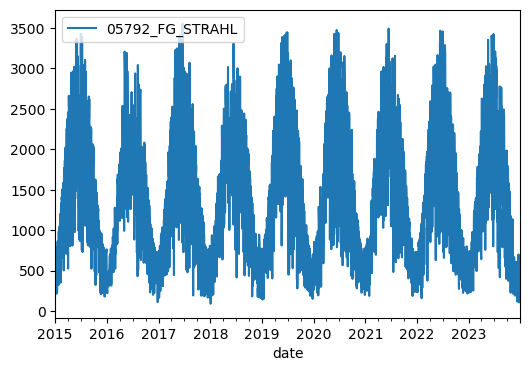

In [36]:
df.plot(x='date',y='05792_FG_STRAHL',figsize=(6,4)) #with NaNs

In [ ]:
import numpy as np
r, c = np.where(df.iloc[:,:-4].isna())
for i in range(len(r)):
    cols_na = [col for col in df.columns if col.endswith(str(df.columns[c[i]])[5:])]
    med_col = df.loc[(df['date'].dt.day==(df.iloc[r[i],0].day)) & (df['date'].dt.month==(df.iloc[r[i],0].month)),df.columns[c[i]]].median()
    
    med_row = df.loc[(df.index==r[i]) & (df['date'].dt.day==(df.iloc[r[i],0].day)) & (df['date'].dt.month==(df.iloc[r[i],0].month)),cols_na].sum().median()
    mean_v = np.nanmean(np.array([med_col,med_row]))
    df.iloc[r[i],c[i]] =mean_v


In [ ]:
### todo ###
#Tagesmedianwerte für Prognosen mit nur Sonnenschein

#for in range(len(df))
#    cols = [col for col in df.columns if col.endswith(str(df.columns[i])[5:])]
#    df.loc[i,''] = df.loc[(df['date'].dt.day==(df.iloc[i,0].day)) & (df['date'].dt.month==(df.iloc[i,0].month)),df.columns[i]].median()

In [ ]:
df.plot(x='date',y='05792_FD_STRAHL',figsize=(10,6)) #with imputed values

<Axes: xlabel='date', ylabel='Act_in_MW'>

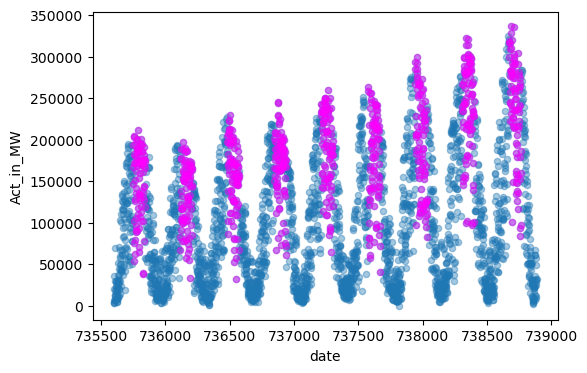

In [72]:
#df.to_csv('us_df_final_2015_2023.csv')
fig, ax1 = plt.subplots(figsize=(6,4))
df.plot.scatter(x='date',y='Act_in_MW',ax=ax1,alpha=0.4)
df.loc[summer,:].plot.scatter(x='date',y='Act_in_MW',ax=ax1,alpha=0.4,color='magenta')

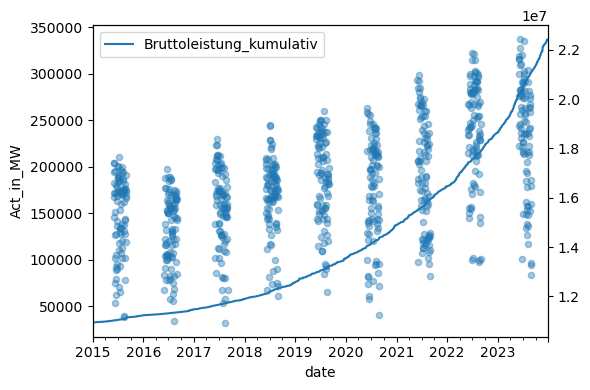

In [49]:
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True,formatter={'float_kind':'{:0.2f}'.format})

summer = (df['date'].dt.month <= 8) & (df['date'].dt.month >= 6)

fig, ax1 = plt.subplots(figsize=(6,4))

df.loc[summer,:].plot.scatter(x='date',y='Act_in_MW',ax=ax1,alpha=0.4)
ax2 = ax1.twinx()
df.plot(x='date',y='Bruttoleistung_kumulativ',ax=ax2) 
fig.tight_layout(
    
)  # otherwise the right y-label is slightly clipped
plt.show()


In [50]:
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.toordinal)

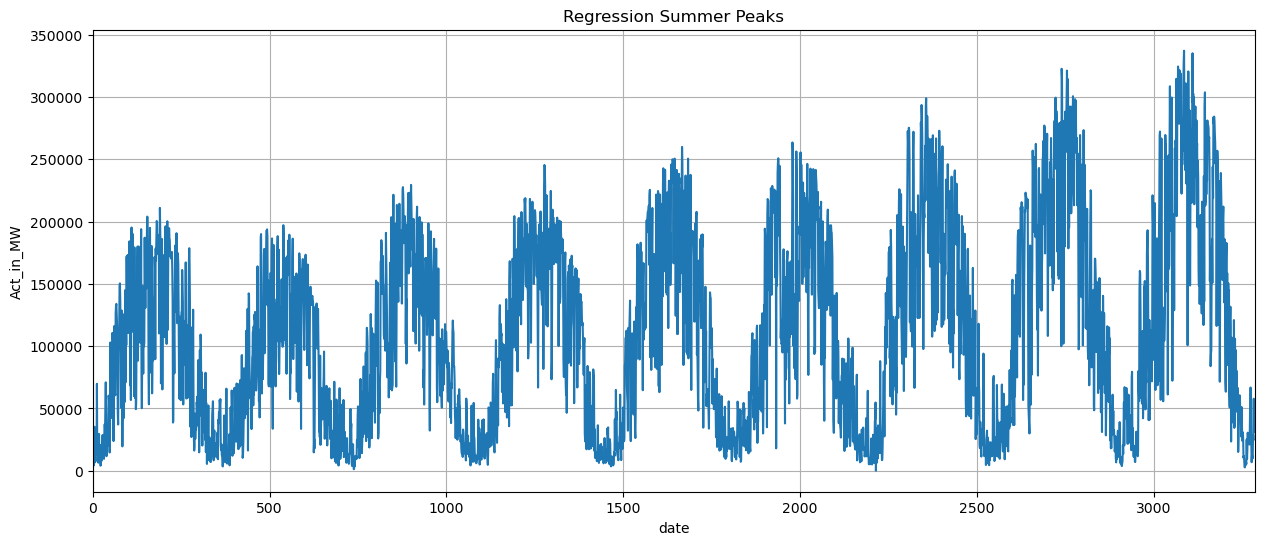

In [29]:
ax1 = df.plot(y='Act_in_MW', figsize=(15, 6), grid=True, legend=False,
              title='Regression Summer Peaks')
sns.regplot(data=df, x='date', y='Act_in_MW', ax=ax1, color='magenta', scatter_kws={'s': 7}, label='Linear Model', scatter=False)

ax1.set_xlim(df.index[0], df.index[-1])

plt.show()

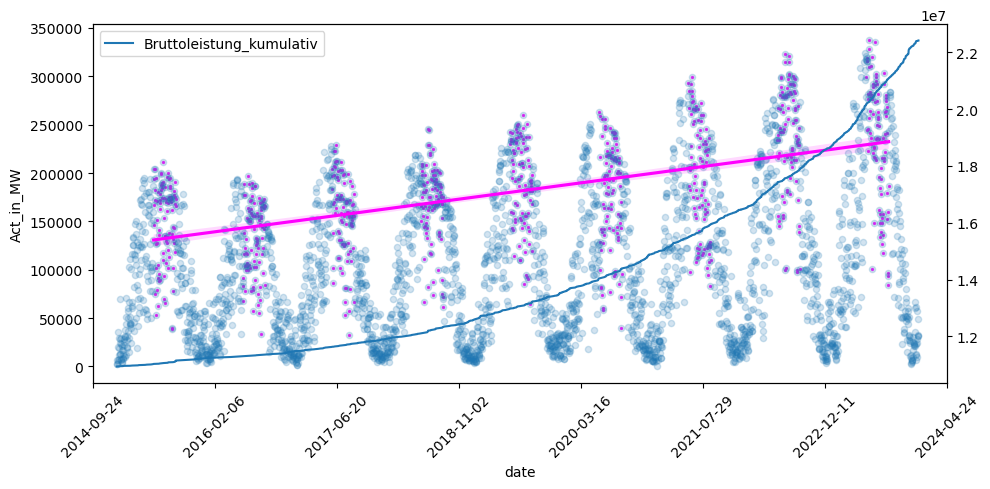

In [90]:
fig, ax1 = plt.subplots(figsize=(10,5))
df_s = df.loc[summer,:]
sns.regplot(data=df_s, x='date', y='Act_in_MW', ax=ax1, color='magenta', scatter_kws={'s': 2})
df.plot.scatter(x='date',y='Act_in_MW',ax=ax1,alpha=0.2)
ax1.set_xlim(df.iloc[0,0], df.iloc[-1,0])
ax2 = ax1.twinx()
df.plot(x='date',y='Bruttoleistung_kumulativ',ax=ax2) 

xticks = ax1.get_xticks()

labels = [pd.Timestamp.fromordinal(int(label)).date() for label in xticks]
ax1.set_xticks(xticks)
ax1.xaxis.set_tick_params(labelrotation=45)
ax1.set_xticklabels(labels)

fig.tight_layout() 
plt.show()

In [78]:
#https://stackoverflow.com/questions/69170874/how-to-plot-a-regression-line-on-a-timeseries-line-plot
#https://readme.so/de/editor

In [ ]:
import requests

stationen = ['Nürnberg',
        'Zugspitze',
       'Fürstenzell',
       'Würzburg',
       'Hohenpeißenberg',
       'Weihenstephan-Dürnast']

url = 'https://kachelmannwetter.com/de/vorhersage/2805615-wuerzburg/kompakt1x1'
# url https://www.wetterkontor.de/wetter-vorhersage/deutschland/wuerzburg
req = requests.get(url)
req

In [ ]:
df = pd.read_csv('../CSV/us_df_final_2015_2023.csv',index_col='Unnamed: 0',parse_dates=['date'])
df.loc[:,'Month'] = df.loc[:,'date'].dt.month
df.loc[:,'Year'] = df.loc[:,'date'].dt.year
df.loc[:,'Calendar_Week'] = df.loc[:,'date'].dt.strftime('%U')
df.head()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,
    gap=365,
    max_train_size=10000,
    test_size=500,
)

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  StandardScaler,OneHotEncoder

def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error","r2"],
        return_estimator=model_prop is not None,
        error_score='raise'
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Mean Absolute Error:       {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Coefficiant of Variation:  {(mae.std()/mae.mean()*100):.2f} %\n"
        f"R2 Score:                  {r2.mean():.2f} \n"
        f"Root Mean Squared Error:   {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )




In [ ]:
X = df[['03668_SD_STRAHL',
    '05792_SD_STRAHL',
    '05856_SD_STRAHL',
   '05705_SD_STRAHL',
    '02290_SD_STRAHL',
    '05404_SD_STRAHL',
    'Bruttoleistung_kumulativ','Nettoleistung_kumulativ','Calendar_Week','Month','Year']]
y = df['Act_in_MW']
for col in ['Month','Year']:
    X[col] = X[col].astype("category")
categorical_columns = np.array(X.columns[X.dtypes == "category"])

from sklearn.ensemble import HistGradientBoostingRegressor
gbr_t = HistGradientBoostingRegressor(random_state=42)

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

one_hot_gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns)
        ],
        remainder=StandardScaler(),
    ),
    gbr_t,
)

evaluate(one_hot_gbrt_pipeline, X, y, cv=ts_cv)

In [ ]:
gbrt = HistGradientBoostingRegressor(categorical_features=categorical_columns,random_state=42)
evaluate(gbrt, X, y, cv=ts_cv)

In [ ]:
from sklearn.kernel_approximation import Nystroem

from sklearn.linear_model import RidgeCV

X = df[['03668_FD_STRAHL','03668_FG_STRAHL','03668_SD_STRAHL',
    '05792_FD_STRAHL','05792_FG_STRAHL','05792_SD_STRAHL',
    '05856_FD_STRAHL','05856_FG_STRAHL','05856_SD_STRAHL',
    '05705_FD_STRAHL','05705_FG_STRAHL','05705_SD_STRAHL',
    '02290_FD_STRAHL','02290_FG_STRAHL','02290_SD_STRAHL',
    '05404_FD_STRAHL','05404_FG_STRAHL','05404_SD_STRAHL',
    'Bruttoleistung_kumulativ','Nettoleistung_kumulativ','Calendar_Week','Month','Year']]

for col in ['Calendar_Week','Month','Year']:
    X[col] = X[col].astype("category")

categorical_columns = np.array(X.columns[X.dtypes == "category"])

alphas = np.logspace(-10, 10, 25)
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns)
        ],
        remainder=StandardScaler(),
    ),
    Nystroem(kernel="rbf", degree=3, n_components=300, random_state=42),
    RidgeCV(alphas=alphas),
)

evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = df[['03668_SD_STRAHL',
    '05792_SD_STRAHL',
    '05856_SD_STRAHL',
   '05705_SD_STRAHL',
    '02290_SD_STRAHL',
    '05404_SD_STRAHL',
    'Bruttoleistung_kumulativ','Nettoleistung_kumulativ','Calendar_Week','Month','Year']]

for col in ['Calendar_Week','Month','Year']:
    X[col] = X[col].astype("category")

categorical_columns = np.array(X.columns[X.dtypes == "category"])

alphas = np.logspace(-10, 10, 25)
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

rf_reg_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns)
        ],
        remainder=StandardScaler(),
    ),
    RandomForestRegressor(n_estimators=100,random_state=42),
)

evaluate(rf_reg_pipeline, X, y, cv=ts_cv)

In [ ]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]

#gbrt.fit(X.iloc[train_0], y.iloc[train_0])
#gbrt_pred = gbrt.predict(X)

one_hot_gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = one_hot_gbrt_pipeline.predict(X)

#one_hot_poly_pipeline.fit(X.iloc[train_1], y.iloc[train_1])
#one_hot_poly_predictions = one_hot_poly_pipeline.predict(X)

rf_reg_pipeline.fit(X.iloc[train_2], y.iloc[train_2])
rf_reg_predictions = rf_reg_pipeline.predict(X)

In [ ]:
last_months = slice(365)
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.values,
    "x-",
    alpha=0.2,
    label="Actual produced",
    color="black",
)
#ax.plot(
#    gbrt_pred,
#    "x-",
#    alpha=0.5,
#    label="Gradient Boosted Trees",
#)
#ax.plot(
#    gbrt_predictions,
#    "x-",
#    label="One-hot + StdScaler + Gradient Boosted Trees",
#)
#x.plot(
#    one_hot_poly_predictions,
#    "x-",
#    alpha=0.5,
#    label="One-hot + rbf kernel",
#)
ax.plot(
    rf_reg_predictions,
    "x-",
    alpha=0.5,
    label="Random Forest Regressor",
)
_ = ax.legend()
#_ = ax.set_xticks(ticks=(list(range(0,180,25))),labels=df.loc[slice(50,230,25),'date'])
#_ = ax.tick_params(axis='x',labelrotation=90)


In [ ]:
import seaborn as sns
sns.heatmap(X.corr().abs())

In [ ]:
# pip install prophet
from prophet import Prophet
import prophet
import Cython 
import cmdstanpy 

In [ ]:
df_p = df.loc[:,['date','Act_in_MW']]
df_p.columns = ['ds','y']
df_p.head()


In [ ]:
m = Prophet()
m.fit(df_p)

In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle("Predictions by Prophet")
ax.plot(
    df.loc[:,'Act_in_MW'],
    "x-",
    label="Actual produced",
    color="black",
)
ax.plot(
    forecast['yhat'],
    "x-",
    label="Prophet",
)
_ = ax.legend()

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)